In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing import image

In [2]:
data_folder = Path("/content/drive/My Drive/train/")

In [3]:
df = pd.read_csv("/content/drive/My Drive/train.csv", sep=',')

In [4]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [4]:
df_train, df_val = train_test_split(df, test_size=0.2)

In [5]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
image_gen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,  # максимальный угол поворота
      width_shift_range=0.20, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.20, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.1, # картинка будет увеличена или уменьшена не более чем на 10% 
      horizontal_flip=True, # случайное отражение по горизонтали
      fill_mode="nearest", # чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
      #cval=0,
      )

In [7]:
BATCH_SIZE = 128
IMAGE_SHAPE = 224

In [9]:
train_generator_emotion_aug = image_gen_aug.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),#batch_size, image_size указаны ниже
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=True,#train_generator должен перемешивать данные, а val_generator -- не должен
)

Found 40036 validated image filenames belonging to 9 classes.


In [10]:
val_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,#train_generator должен перемешивать данные, а val_generator -- не должен
)

Found 10010 validated image filenames belonging to 9 classes.


In [11]:
IMG_SIZE = (224, 224, 3)
# базовая модель -- MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
base_model.trainable = False

In [13]:
path = Path("drive/MyDrive/model_3_emotion")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

In [13]:
cpt_path

'drive/MyDrive/model_3_emotion/checkpoint_best.h5'

In [14]:
model_3 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(1024, input_shape=IMG_SIZE, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(27, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(9, activation='softmax')
])

In [15]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

In [16]:
checkpoint = [tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'), 
              tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [17]:
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dense (Dense)                (None, 7, 7, 1024)        1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 512)         524800    
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 256)         131328    
_________________________________________________________________
dense_3 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dense_4 (Dense)              (None, 7, 7, 64)          8256      
_________________________________________________________________
dense_5 (Dense)              (None, 7, 7, 32)          2

In [ ]:
EPOCHS = 15
history_3 = model_3.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
25/25 [==============================] - 2922s 119s/step - loss: 2.1411 - accuracy: 0.1688 - val_loss: 2.1129 - val_accuracy: 0.2117

Epoch 00001: val_accuracy improved from -inf to 0.21169, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 2/15
25/25 [==============================] - 1786s 72s/step - loss: 2.0956 - accuracy: 0.1981 - val_loss: 2.0630 - val_accuracy: 0.2209

Epoch 00002: val_accuracy improved from 0.21169 to 0.22088, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 3/15
25/25 [==============================] - 1757s 71s/step - loss: 2.0585 - accuracy: 0.2131 - val_loss: 2.1752 - val_accuracy: 0.1813

Epoch 00003: val_accuracy did not improve from 0.22088
Epoch 4/15
25/25 [==============================] - 1664s 67s/step - loss: 2.0559 - accuracy: 0.2203 - val_loss: 2.0270 - val_accuracy: 0.2442

Epoch 00004: val_accuracy improved from 0.22088 to 0.24416, saving model to drive/MyDrive/model_3_emotion/checkpoint_best

In [ ]:
EPOCHS = 20
model_3_sec = load_model("drive/My Drive/model_3_emotion/checkpoint_best.h5")
history_2 = model_3_sec.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 15,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 16/20
25/25 [==============================] - 6420s 264s/step - loss: 1.8556 - accuracy: 0.3075 - val_loss: 1.9358 - val_accuracy: 0.2879

Epoch 00016: val_accuracy improved from -inf to 0.28791, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 17/20
25/25 [==============================] - 1927s 77s/step - loss: 1.8978 - accuracy: 0.2903 - val_loss: 1.9078 - val_accuracy: 0.2865

Epoch 00017: val_accuracy did not improve from 0.28791
Epoch 18/20
25/25 [==============================] - 1780s 72s/step - loss: 1.9109 - accuracy: 0.2828 - val_loss: 1.9970 - val_accuracy: 0.2707

Epoch 00018: val_accuracy did not improve from 0.28791
Epoch 19/20
25/25 [==============================] - 1682s 68s/step - loss: 1.8908 - accuracy: 0.2978 - val_loss: 1.9272 - val_accuracy: 0.2957

Epoch 00019: val_accuracy improved from 0.28791 to 0.29570, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 20/20
25/25 [==============================] - 1569s 63s

In [17]:
EPOCHS = 30
model_3_third = load_model("drive/My Drive/model_3_emotion/checkpoint_best.h5")
history_2 = model_3_third.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 28,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 29/30
25/25 [==============================] - 9219s 380s/step - loss: 1.8495 - accuracy: 0.3262 - val_loss: 1.9227 - val_accuracy: 0.2914

Epoch 00029: val_accuracy improved from -inf to 0.29141, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 30/30
25/25 [==============================] - 2013s 81s/step - loss: 1.8298 - accuracy: 0.3284 - val_loss: 1.9127 - val_accuracy: 0.2994

Epoch 00030: val_accuracy improved from 0.29141 to 0.29940, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5


In [17]:
EPOCHS = 40
model_3_forth = load_model("drive/My Drive/model_3_emotion/checkpoint_best.h5")
history_2 = model_3_forth.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 33,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 34/40
25/25 [==============================] - 9507s 392s/step - loss: 1.8179 - accuracy: 0.3272 - val_loss: 1.8774 - val_accuracy: 0.3080

Epoch 00034: val_accuracy improved from -inf to 0.30799, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 35/40
25/25 [==============================] - 2082s 83s/step - loss: 1.7981 - accuracy: 0.3416 - val_loss: 1.9028 - val_accuracy: 0.3018

Epoch 00035: val_accuracy did not improve from 0.30799
Epoch 36/40
25/25 [==============================] - 1866s 75s/step - loss: 1.8052 - accuracy: 0.3431 - val_loss: 1.9035 - val_accuracy: 0.2986

Epoch 00036: val_accuracy did not improve from 0.30799
Epoch 37/40
25/25 [==============================] - 1665s 67s/step - loss: 1.8063 - accuracy: 0.3384 - val_loss: 1.8712 - val_accuracy: 0.3091

Epoch 00037: val_accuracy improved from 0.30799 to 0.30909, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 38/40
25/25 [==============================] - 1583s 64s

In [18]:
df_test = pd.read_csv("/content/drive/My Drive/sample_submission.csv", sep=',')

In [19]:
df_test.head()

,image_path,emotion
0,0.jpg,neutral
1,1.jpg,neutral
2,2.jpg,neutral
3,3.jpg,neutral
4,4.jpg,neutral


In [19]:
test_data_folder = Path("/content/drive/My Drive/test_kaggle/test_kaggle/")

In [20]:
test_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_test,
    directory=str(test_data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 5000 validated image filenames belonging to 1 classes.


In [21]:
model_emotion_3 = load_model("drive/My Drive/model_3_emotion/checkpoint_best.h5")
loss, acc = model_emotion_3.evaluate(val_generator_emotion)
if acc < 0.29880:
    print("Please, try harder!")
else:
    if acc >= 0.4:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

79/79 [==============================] - 4467s 57s/step - loss: 1.8428 - accuracy: 0.3257
Very good! Can you improve accuracy?


In [22]:
predicted_classes_3 = model_emotion_3.predict_classes(test_generator_emotion)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [23]:
len(predicted_classes_3)

5000

In [24]:
sample_validation_images, sample_validation_labels = next(val_generator_emotion)

In [25]:
predicted = model_emotion_3.predict_classes(sample_validation_images).flatten()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [26]:
def show_emotions(images, labels, predicted_labels=None):
    names = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] + 1)/2., cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

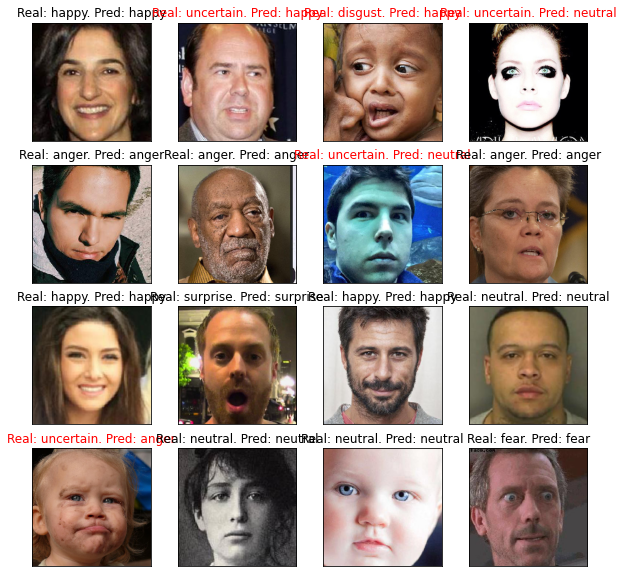

In [27]:
show_emotions(sample_validation_images, sample_validation_labels, predicted)

In [28]:
classes_mapping = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}

In [ ]:
classes_mapping.keys

<function dict.keys>

In [29]:
classes_3 = []
for i in predicted_classes_3:
  classes_3.append(classes_mapping[i])

In [30]:
test_images = df_test['image_path'].to_list()

In [31]:
def write_to_submission_file(predictions, test_images, out_file='Submission.csv', columns=['image_path', 'emotion']):
    predicted_df = pd.DataFrame(list(zip(test_images, predictions)), columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [33]:
write_to_submission_file(classes_3, test_images, out_file='Submission_3.csv', columns=['image_path', 'emotion'])